# 一维CNN实现三类信号识别

<!-- TOC -->

- [一维CNN实现三类信号识别](#一维cnn实现三类信号识别)
    - [基于联合采集数据集](#基于联合采集数据集)
        - [一维信号分类结果](#一维信号分类结果)
        - [二维信号分类结果](#二维信号分类结果)
    - [基于混合数据集](#基于混合数据集)
        - [一维混合信号分类结果](#一维混合信号分类结果)
        - [二维混合信号分类结果](#二维混合信号分类结果)

<!-- /TOC -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## 基于联合采集数据集

- 数据集来源：对前中后三个光纤同时进行脚踏、手触和棒击操作
- 数据集制作（过程详见[wave_dataset]()）：
  - 一维信号：有4995条训练数据，501条验证数据，501条测试数据
  - 多组一维信号叠加的二维信号：有4869条训练数据，489条验证数据，489条测试数据

In [2]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []
with open('three/train_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_train.append([int(x) for x in temp])
with open('three/val_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_val.append([int(x) for x in temp])
with open('three/test_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_test.append([int(x) for x in temp])
with open('three/train_label.txt','r') as f:
    for line in f:
        Y_train.append(line.strip())
with open('three/val_label.txt','r') as f:
    for line in f:
        Y_val.append(line.strip())
with open('three/test_label.txt','r') as f:
    for line in f:
        Y_test.append(line.strip())
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [3]:
# 升维
X_train, X_val, X_test = np.expand_dims(X_train,axis = 1),np.expand_dims(X_val,axis = 1),np.expand_dims(X_test,axis = 1)
Y_train, Y_val, Y_test = np.expand_dims(Y_train,axis = 1),np.expand_dims(Y_val,axis = 1),np.expand_dims(Y_test,axis = 1)

In [4]:
X_train.shape

(4995, 1, 50)

### 一维信号分类结果

- 4995条训练数据，501条验证数据，501条测试数据
- 训练集准确率为0.9453125, 测试集准确率为0.9061876535415649


In [5]:
batch_size = 256

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

In [15]:
epochs = 30
num_blocks = 3
filters = 128
drop_rate = 0.5
num_class = 3

X = Input(shape=(1,50), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 2, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 2, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 2, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 2, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 2, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/30
19/19 [==============================] - 257s 14s/step - loss: 0.6320 - accuracy: 0.7568 - val_loss: 9.4608 - val_accuracy: 0.3359
Epoch 2/30
19/19 [==============================] - 3s 177ms/step - loss: 0.4503 - accuracy: 0.8347 - val_loss: 2.1400 - val_accuracy: 0.4844
Epoch 3/30
19/19 [==============================] - 3s 178ms/step - loss: 0.3780 - accuracy: 0.8602 - val_loss: 0.6984 - val_accuracy: 0.7305
Epoch 4/30
19/19 [==============================] - 3s 178ms/step - loss: 0.3712 - accuracy: 0.8600 - val_loss: 1.0526 - val_accuracy: 0.7031
Epoch 5/30
19/19 [==============================] - 3s 172ms/step - loss: 0.3233 - accuracy: 0.8787 - val_loss: 0.4733 - val_accuracy: 0.8672
Epoch 6/30
19/19 [==============================] - 3s 176ms/step - loss: 0.3069 - accuracy: 0.8836 - val_loss: 0.6636 - val_accuracy: 0.8203
Epoch 7/30
19/19 [==============================] - 4s 187ms/step - loss: 0.2834 - accuracy: 0.8941 - val_loss: 0.8991 - val_accuracy: 0.7539
Epoch 

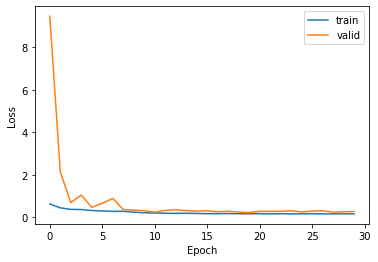

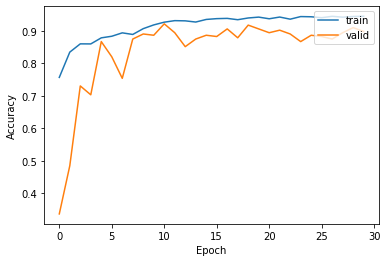

In [16]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [17]:
# 准确率
print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

训练集loss为0.16494275355025342，准确率为0.9453125
验证集loss为0.2779066562652588，准确率为0.8984375
测试集loss为0.2515614760106433，准确率为0.9061876535415649


In [18]:
# 对测试集任一信号进行分类
num = 34
prediction = model.predict(np.expand_dims(X_test[num],axis=0))
prediction = np.argmax(prediction, axis=1)[0]
label = ['noraml','foot','hand','stick']
print('预测结果是{}，其标签为{}'.format(label[prediction], label[int(Y_test[num][0])]))

预测结果是foot，其标签为foot


### 二维信号分类结果

- 4869条训练数据，489条验证数据，489条测试数据
- 训练集准确率为1.0, 测试集准确率为1.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D,Conv2D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

with open('three2D/train_data.txt','r') as f:
    for line in f:
        X_train.append(line.strip().split('\t'))
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = [int(x) for x in X_train[i][j].strip('[]').split(',')]

with open('three2D/val_data.txt','r') as f:
    for line in f:
        X_val.append(line.strip().split('\t'))
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        X_val[i][j] = [int(x) for x in X_val[i][j].strip('[]').split(',')]

with open('three2D/test_data.txt','r') as f:
    for line in f:
        X_test.append(line.strip().split('\t'))
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = [int(x) for x in X_test[i][j].strip('[]').split(',')]        

with open('three2D/train_label.txt','r') as f:
    for line in f:
        Y_train.append(line.strip())
with open('three2D/val_label.txt','r') as f:
    for line in f:
        Y_val.append(line.strip())
with open('three2D/test_label.txt','r') as f:
    for line in f:
        Y_test.append(line.strip())
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [3]:
X_train.shape

(4869, 50, 50)

In [4]:
batch_size = 64

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

In [5]:
epochs = 20
num_blocks = 3
filters = 64
drop_rate = 0.8
num_class = 3

X = Input(shape=(50,50), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 3, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 3, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 3, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 3, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 3, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/20


W1225 03:16:51.223271 139819754923840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1225 03:17:21.986194 139819754923840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


76/76 [==============================] - 81s 1s/step - loss: 0.3746 - accuracy: 0.8604 - val_loss: 2.9455 - val_accuracy: 0.3549
Epoch 2/20
76/76 [==============================] - 11s 141ms/step - loss: 0.0481 - accuracy: 0.9901 - val_loss: 1.1298 - val_accuracy: 0.8080
Epoch 3/20
76/76 [==============================] - 10s 138ms/step - loss: 0.0454 - accuracy: 0.9907 - val_loss: 1.1112 - val_accuracy: 0.7009
Epoch 4/20
76/76 [==============================] - 11s 139ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.0270 - val_accuracy: 0.9911
Epoch 5/20
76/76 [==============================] - 11s 138ms/step - loss: 0.0226 - accuracy: 0.9940 - val_loss: 1.8435 - val_accuracy: 0.7143
Epoch 6/20
76/76 [==============================] - 10s 138ms/step - loss: 0.0069 - accuracy: 0.9994 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/20
76/76 [==============================] - 10s 137ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 8/20
76

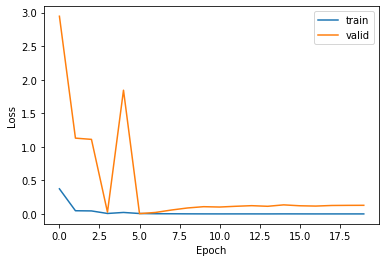

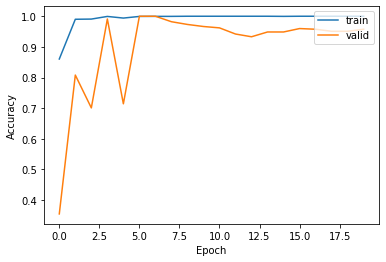

In [6]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [7]:
# 准确率
print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

训练集loss为0.0008906088095452441，准确率为1.0
验证集loss为0.12899631474699294，准确率为0.9575892686843872
测试集loss为0.012940163985999389，准确率为1.0


In [8]:
# 保存模型
model.save('DVS2D.h5')
model.save_weights('DVS2D_weights.h5')

## 基于混合数据集

- 数据来源：
  - 对前中后三个光纤同时进行脚踏、手触和棒击操作
  - 分别对前中后三个光纤进行脚踏、手触和棒击操作
- 数据集制作（过程详见[wave_dataset]()）
  - 一维信号：有19992条训练数据，1998条验证数据，1998条测试数据
  - 二维信号：有19866条训练数据，1986条验证数据，1986条测试数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []
with open('mix/train_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_train.append([int(x) for x in temp])
with open('mix/val_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_val.append([int(x) for x in temp])
with open('mix/test_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_test.append([int(x) for x in temp])
with open('mix/train_label.txt','r') as f:
    for line in f:
        Y_train.append(line.strip())
with open('mix/val_label.txt','r') as f:
    for line in f:
        Y_val.append(line.strip())
with open('mix/test_label.txt','r') as f:
    for line in f:
        Y_test.append(line.strip())
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [5]:
# 升维
X_train, X_val, X_test = np.expand_dims(X_train,axis = 1),np.expand_dims(X_val,axis = 1),np.expand_dims(X_test,axis = 1)
Y_train, Y_val, Y_test = np.expand_dims(Y_train,axis = 1),np.expand_dims(Y_val,axis = 1),np.expand_dims(Y_test,axis = 1)
X_train.shape

(19992, 1, 50)

### 一维混合信号分类结果

- 19992条训练数据，1998条验证数据，1998条测试数据
- 训练集准确率为0.7682291865348816, 测试集准确率为0.7077077031135559

In [6]:
batch_size = 128
epochs = 20
num_blocks = 3
filters = 128
drop_rate = 0.8
num_class = 3

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

X = Input(shape=(1,50), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 3, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 3, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 3, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 3, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 3, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/20


W1225 06:09:38.320131 140546550105920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1225 06:10:09.167811 140546550105920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


156/156 [==============================] - 93s 594ms/step - loss: 0.9889 - accuracy: 0.5043 - val_loss: 1.0502 - val_accuracy: 0.5198
Epoch 2/20
156/156 [==============================] - 23s 145ms/step - loss: 0.8925 - accuracy: 0.5736 - val_loss: 0.9768 - val_accuracy: 0.5604
Epoch 3/20
156/156 [==============================] - 22s 143ms/step - loss: 0.8548 - accuracy: 0.6019 - val_loss: 0.9043 - val_accuracy: 0.6146
Epoch 4/20
156/156 [==============================] - 22s 143ms/step - loss: 0.8117 - accuracy: 0.6307 - val_loss: 0.9076 - val_accuracy: 0.6203
Epoch 5/20
156/156 [==============================] - 22s 141ms/step - loss: 0.7913 - accuracy: 0.6418 - val_loss: 0.8459 - val_accuracy: 0.6203
Epoch 6/20
156/156 [==============================] - 22s 139ms/step - loss: 0.7679 - accuracy: 0.6518 - val_loss: 0.8483 - val_accuracy: 0.6323
Epoch 7/20
156/156 [==============================] - 21s 137ms/step - loss: 0.7569 - accuracy: 0.6583 - val_loss: 0.8730 - val_accuracy: 0.6

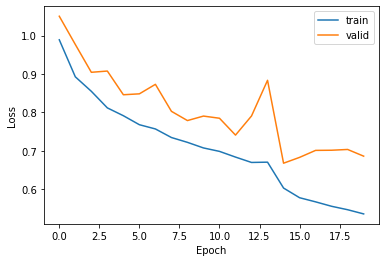

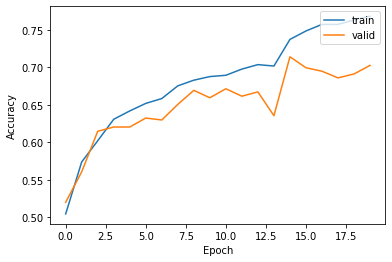

训练集loss为0.5357248085813645，准确率为0.7682291865348816
验证集loss为0.6860355893770854，准确率为0.7026041746139526
测试集loss为0.6904389860632422，准确率为0.7077077031135559


In [7]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

### 二维混合信号分类结果

- 19866条训练数据，1986条验证数据，1986条测试数据
- 训练集准确率为0.9996955990791321, 测试集准确率为0.9003021121025085

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

with open('mix2D/train_data.txt','r') as f:
    for line in f:
        X_train.append(line.strip().split('\t'))
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = [int(x) for x in X_train[i][j].strip('[]').split(',')]

with open('mix2D/val_data.txt','r') as f:
    for line in f:
        X_val.append(line.strip().split('\t'))
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        X_val[i][j] = [int(x) for x in X_val[i][j].strip('[]').split(',')]

with open('mix2D/test_data.txt','r') as f:
    for line in f:
        X_test.append(line.strip().split('\t'))
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = [int(x) for x in X_test[i][j].strip('[]').split(',')]        

with open('mix2D/train_label.txt','r') as f:
    for line in f:
        Y_train.append(line.strip())
with open('mix2D/val_label.txt','r') as f:
    for line in f:
        Y_val.append(line.strip())
with open('mix2D/test_label.txt','r') as f:
    for line in f:
        Y_test.append(line.strip())
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [3]:
X_train.shape

(19866, 50, 50)

In [4]:
batch_size = 256
epochs = 10
num_blocks = 3
filters = 128
drop_rate = 0.5
num_class = 3

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

X = Input(shape=(50,50), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 7, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 7, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 7, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 7, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 7, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/10


W1225 07:00:46.604415 140206232676160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1225 07:01:18.623269 140206232676160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


77/77 [==============================] - 91s 1s/step - loss: 0.6014 - accuracy: 0.7301 - val_loss: 10.2573 - val_accuracy: 0.3365
Epoch 2/10
77/77 [==============================] - 19s 253ms/step - loss: 0.1338 - accuracy: 0.9550 - val_loss: 7.0286 - val_accuracy: 0.4487
Epoch 3/10
77/77 [==============================] - 20s 259ms/step - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.5423 - val_accuracy: 0.9330
Epoch 4/10
77/77 [==============================] - 20s 255ms/step - loss: 0.0546 - accuracy: 0.9829 - val_loss: 2.2989 - val_accuracy: 0.7494
Epoch 5/10
77/77 [==============================] - 19s 253ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 1.0726 - val_accuracy: 0.8253
Epoch 6/10
77/77 [==============================] - 19s 251ms/step - loss: 0.0185 - accuracy: 0.9952 - val_loss: 1.7219 - val_accuracy: 0.8398
Epoch 7/10
77/77 [==============================] - 19s 253ms/step - loss: 0.0090 - accuracy: 0.9985 - val_loss: 0.6548 - val_accuracy: 0.8968
Epoch 8/10
7

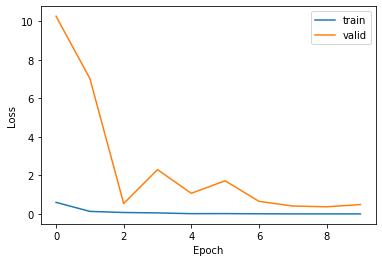

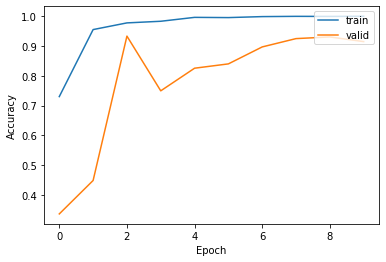

训练集loss为0.0024497248323077894，准确率为0.9996955990791321
验证集loss为0.4882708362170628，准确率为0.9146205186843872
测试集loss为0.3124129925516865，准确率为0.9003021121025085


In [5]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))